In [1]:
save_figures = True

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import pandas as pd
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
from auxiliary_code.helper_functions import *

In [3]:
get_center = lambda bbox: [(bbox[0]+bbox[2])/2, (bbox[1] + bbox[3])/2]
df_shape = get_shape_file('../geography/Somalia/Som_Admbnda_Adm2_UNDP.shp')
df_loc = pd.read_csv('../datasets/locations.csv').iloc[:-1, 1:].drop_duplicates()
df_loc.columns = ['district', 'lat', 'long']
df_loc['district'] = df_loc['district'].str.lower()
df_loc.set_index('district', inplace=True)

In [17]:
tweet_df = pd.read_csv('../sentiment_datasets/somalia_tweets.csv', parse_dates=['date'])
# the mode is the most common location, it is the center of the country
# it is assigned to tweets where no accurate geotag can be provided.
mode =tweet_df[['long', 'lat']].mode()
mask = (tweet_df['long'] == float(mode['long'])) & (tweet_df['lat'] == float(mode['lat']))
tweet_df.loc[mask, 'long'] = None
tweet_df.loc[mask, 'lat'] = None
print(f'{(~mask).sum()} valid geotags')

4726 valid geotags


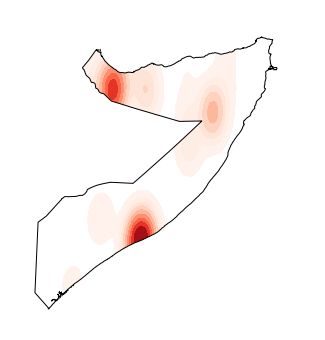

In [6]:
ax = geoplot.kdeplot(gpd.GeoDataFrame(geometry=gpd.points_from_xy(tweet_df[~mask].long, tweet_df[~mask].lat)), projection=gcrs.AlbersEqualArea(), cmap='Reds', shade=True, clip=df_shape, alpha=1)
geoplot.polyplot(df_shape.dissolve().boundary, ax=ax, zorder=1000);

if save_figures:
    plt.savefig('../figures/tweets_location_original.pdf', format='pdf')

In [18]:
def f(s, col):
    l = []
    for name in df_loc.index:
        if name in s:
            return df_loc.loc[name][col]
        
    return None

new_longs = tweet_df['text'].str.lower().apply(lambda s: f(s, 'long'))
new_lats = tweet_df['text'].str.lower().apply(lambda s: f(s, 'lat'))
tweet_df.loc[mask, 'long'] = new_longs.loc[mask]
tweet_df.loc[mask, 'lat'] = new_lats.loc[mask]

print(f'{(~new_longs.isna()).sum()} new estimated locations')

10501 new estimated locations


In [54]:
na_mask = tweet_df['lat'].isna()
locs_known = tweet_df[~na_mask].iloc[:, 1:]
imputed_locs = locs_known.groupby('author_id')[['long', 'lat']].mean()
final = tweet_df.merge(imputed_locs, left_on='author_id', right_index=True).rename({'long_x': 'long', 'lat_x': 'lat'}, axis=1).copy()
#final.loc[na_mask, ['long', 'lat']] = final.loc[na_mask, ['long_y', 'lat_y']]
final['long'] = final['long'].fillna(final['long_y'])
final['lat'] = final['lat'].fillna(final['lat_y'])
print(f'{(~na_mask).sum() - final.long_y.isna().sum()} new imputed locations')
final = final.drop(['long_y', 'lat_y'], axis=1).dropna()
print(f'{len(final)} number of geotagged tweets obtained')

15030 new imputed locations
172958 number of geotagged tweets obtained


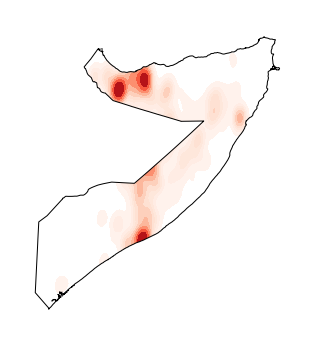

In [55]:
ax = geoplot.kdeplot(gpd.GeoDataFrame(geometry=gpd.points_from_xy(final.long, final.lat)), projection=gcrs.AlbersEqualArea(), cmap='Reds', shade=True, clip=df_shape, alpha=1)
geoplot.polyplot(df_shape.dissolve().boundary, ax=ax, zorder=1000);

if save_figures:
    plt.savefig('../figures/tweets_locations_final.pdf', format='pdf')

In [58]:
final.to_csv('../datasets/twitter/tweets_location_corrected.csv', index=False)